In [157]:
# Handy widget for matplotlib
%matplotlib widget

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ipympl
import imageio.v3 as iio
import skimage
import os

In [179]:
# Make a variable to the image that we want to use beacuse reasons

# image_file = 'memorial.jpg'
image_file = 'aurebesh.jpg'

In [180]:
# Read the image in as image and image_gray
image = iio.imread(uri=image_file)
image_gray = iio.imread(uri=image_file, mode="L")

# What's Working

1. Grayscale image
2. Local thresholding
3. Closing


## Local Thresholding

If the background of an image is fairly uniform, global thresholding usually does the trick. However, when the background of an image is messy, local thresholding tends to be more successful.

Local thresholding works by calculating thresholds in blocks surrounding each pixel. The threshold value that get applied is the result of the weighted mean of the local neighbors minus an offset value.

[scikit-image.org](https://scikit-image.org/docs/dev/auto_examples/applications/plot_thresholding_guide.html#sphx-glr-auto-examples-applications-plot-thresholding-guide-py)

In [203]:
from skimage.filters import threshold_local

block_size = 25
local_thresh = threshold_local(image_gray, block_size, 'gaussian', offset=1)
binary_local = image_gray > local_thresh

In [ ]:
plt.close()

fig, axes = plt.subplots(ncols=2, nrows=1)
ax = axes.ravel()
plt.gray()

ax[0].imshow(image_gray)
ax[0].set_title('Original')

ax[1].imshow(binary_local)
ax[1].set_title('Local thresholding')

for a in ax:
    a.axis('off')

In [166]:
def local_thresholding(image_gray, block_size, method, offset):
    local_thresh = threshold_local(image_gray, block_size, method, offset=offset)
    binary_local = image_gray > local_thresh

    return binary_local

In [167]:
# Control: Uses the same settings as I had originally
original_local_thresh = local_thresholding(image_gray, 35, 'gaussian', 10)

# Test 00: Sets the offset
offset_local_thresh = local_thresholding(image_gray, 35, 'gaussian', 15)

# Test 01: Sets the block_size
block_local_thresh = local_thresholding(image_gray, 75, 'gaussian', 10)

# Test 02: Sets the method
method_local_thresh = local_thresholding(image_gray, 35, 'mean', 10)

# Test 03: Combining tests
combine_local_thresh = local_thresholding(image_gray, 9, 'mean', 5)

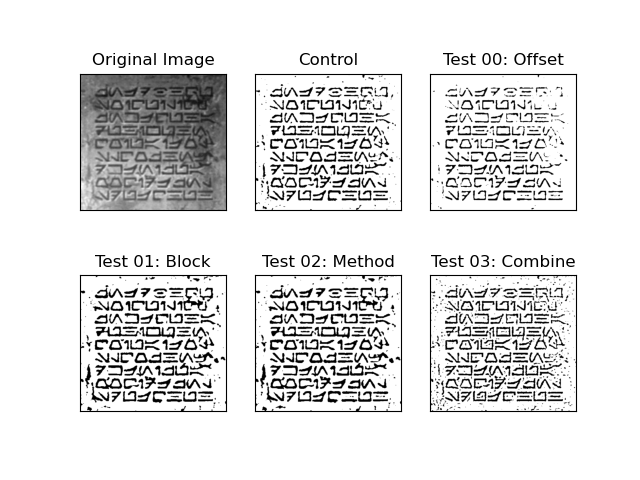

In [168]:
plt.close()

titles = ['Original Image', 'Control', 'Test 00: Offset', 'Test 01: Block', 'Test 02: Method', 'Test 03: Combine']
images = [image_gray, original_local_thresh, offset_local_thresh, block_local_thresh, method_local_thresh, combine_local_thresh]

for i in range(len(images)):
    plt.subplot(2, 3, i+1), plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()

After testing a variety of parameters for the `threshold_local()` function, the control still seems to be performing the best.

## Adaptive Gaussian Thresholding

Adaptive thresholding performs better on images where the lighting changes in different areas of the image. An adaptive thresholding algorithm determines the threshold for each pixel by examining the region around that pixel.

[docs.opencv.org](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)

In [ ]:
image_blur = cv.medianBlur(image_gray, 5)

gauss_thresh = cv.adaptiveThreshold(image_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)


In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1)
ax = axes.ravel()
plt.gray()

ax[0].imshow(image_gray)
ax[0].set_title('Original')

ax[1].imshow(gauss_thresh)
ax[1].set_title('Adaptive Gaussian')

for a in ax:
    a.axis('off')

plt.show()


## Comparing Local and Adaptive Gasussian Thresholding

The local thresholding results in a much cleaner image that the adaptive Gaussian thresholding. Fewer artifacts remain in the image after the local thresholding, making it easier to isolate the letters from the background.

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1)
ax = axes.ravel()
plt.gray()

ax[0].imshow(binary_local)
ax[0].set_title('Local Thresholding')

ax[1].imshow(gauss_thresh)
ax[1].set_title('Adaptive Gaussian Thresholding')

for a in ax:
    a.axis('off')

plt.show()

# Let's Try New Things

## Can we clean the image further?

The local thresholding results in a great looking image where the letters are fairly clear. However, there is still a bit of noise in the image, namely all the little flecks and dots that are artifacts from the original image. So, the question is, how can we get rid of these nussances?

### Test 00: Hysteresis Thresholding

Hysteresis is the lagging of an effect, similar to inertia. What this means in thresholding is that only areas that are above a low threshold and are connected to areas above a high threshold are considered. Those low threshold areas can be taken as continuations of high-confidence areas.

The thresholding technique relies on Sobel edge detection.

[scikit-image.org](https://scikit-image.org/docs/dev/auto_examples/filters/plot_hysteresis.html#sphx-glr-auto-examples-filters-plot-hysteresis-py)

In [183]:
# Use Sobel edge detection to find the edges in the image
edges = skimage.filters.sobel(binary_local)

# Set the low and high threshold values (between 0 and 1)
low = 0.2
high = 0.4

# Prep the thresholds for plotting
lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = skimage.filters.apply_hysteresis_threshold(edges, low, high)


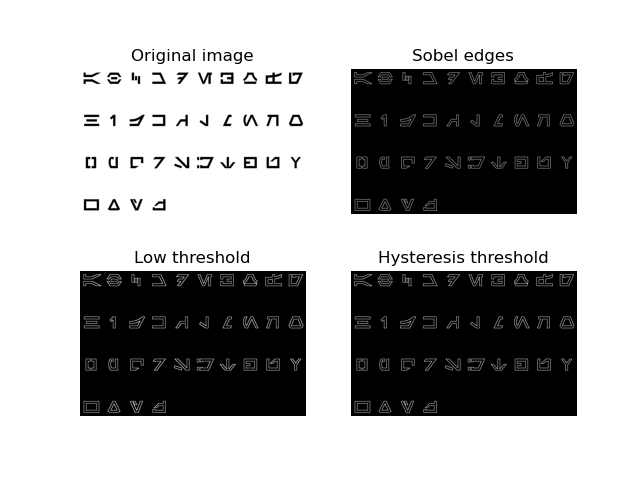

In [185]:
# Get the plots ready to go
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].imshow(binary_local, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(edges, cmap='gray')
ax[0, 1].set_title('Sobel edges')

ax[1, 0].imshow(lowt, cmap='gray')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hight + hyst, cmap='gray')
ax[1, 1].set_title('Hysteresis threshold')

for a in ax.ravel():
    a.axis('off')

# Show the plots
# plt.tight_layout()
plt.show()

The Sobel edge detection and the Hysteresis threshold were both performed on the local threshold result (`binary_local`). When these methods are used on `image_gray`, the results are varied. Sobel edge detection performs okay on the grayscale image, but the other two thresholds do not provide reasonable results at all.

### Test 01: Morphological Transformations

There are two main types of morphological transformation: erosion and dilation. These transformations conduct simple image-shape based operations, one which erodes away the boundaries of foreground objects and the other which increases the size of an object.

These two main operations can be combines to create variant operations such as closing and opening.

[docs.opencv.org](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html)

In [169]:
# Invert the binary_local image to help the morphological transformations perform correctly
inverted_image = skimage.util.invert(binary_local)

# Convert the scikit-image to an opencv-friendly object
cv_image = skimage.img_as_ubyte(inverted_image)

# Run the calculations
kernel = np.ones((3,3), np.uint8)

erosion = cv.erode(cv_image, kernel, iterations=1)
dilation = cv.dilate(cv_image, kernel, iterations=1)
opening = cv.morphologyEx(cv_image, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(cv_image, cv.MORPH_CLOSE, kernel)

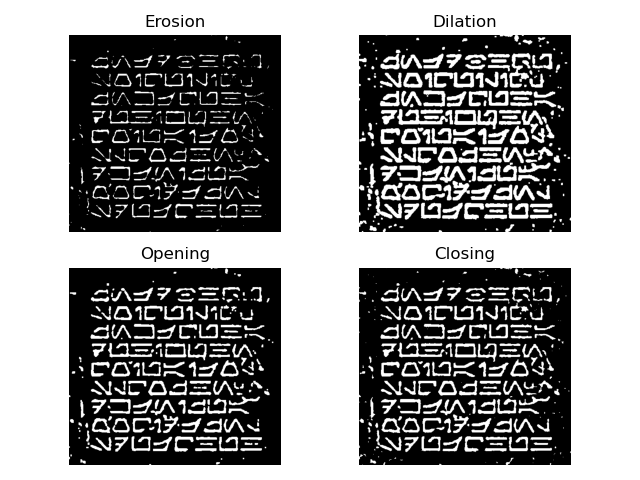

In [174]:
plt.close()

# Get the plots ready to go
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].imshow(erosion, cmap='gray')
ax[0, 0].set_title('Erosion')

ax[0, 1].imshow(dilation, cmap='gray')
ax[0, 1].set_title('Dilation')

ax[1, 0].imshow(opening, cmap='gray')
ax[1, 0].set_title('Opening')

# ax[1, 0].imshow(binary_local, cmap='gray')
# ax[1, 0].set_title('Local Threshold')

ax[1, 1].imshow(closing, cmap='gray')
ax[1, 1].set_title('Closing')

for a in ax.ravel():
    a.axis('off')

# Show the plots
plt.tight_layout()
plt.show()


The most useful result of this test with morphological transformations appears to be closing.

When the kernel value was set to (3,3), the results were the most favorable.

Below, the inverted binary_local result and the closing result are compared.

In [ ]:
# Get the plots ready to go
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(inverted_image, cmap='gray')
ax[0].set_title('Local Threshold')

ax[1].imshow(closing, cmap='gray')
ax[1].set_title('Closing')

for a in ax.ravel():
    a.axis('off')

# Show the plots
plt.tight_layout()
plt.show()


The closing method of morphological transformation provides letters with much more clean edges and fewer pixelated gaps or chinks. Noise was not reduced, but the letters themselves look much more clean.

## Test 02: Connected Component Analysis

The output of the closing morphological method is an ndarray of ndarrays with values of 0 or 255 depending on whether or not the pixel is black or white. What we need to do next is figure out how to identify objects within this list of lists.

In order to find the objects, we can use connnected component analysis (CCA), which takes a binary image as input, which we have (hence `binary_local`). CCA produces a new image integer values for each pixel where the values that are the same belong to the same object in the image.

In [ ]:
def connected_components(binary_image, connectivity):
    label_image, count = skimage.measure.label(binary_image, connectivity=connectivity, return_num=True)

    return label_image, count

In [ ]:
label_image, count = connected_components(closing, 2)

In [ ]:
plt.close()
fig, ax = plt.subplots()
plt.imshow(label_image, cmap='tab20b')
# plt.axis("off")

In [ ]:
region_props = skimage.measure.regionprops(label_image)

# i = 0
# for prop in region_props:
#    if region_props[i].area > 100:
#       print(region_props[i].label, region_props[i].coords)
#    i+=1

In [ ]:
plt.close()

fig, ax = plt.subplots()
plt.imshow(region_props[50].image)

In [ ]:
from PIL import Image as im

data = im.fromarray(region_props[50].image)
data.save('test00.png')
image = cv.imread('test00.png', 0)

# Run the calculations
kernel = np.ones((3,3), np.uint8)

erosion = cv.erode(image, kernel, iterations=1)
dilation = cv.dilate(image, kernel, iterations=1)
opening = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)

plt.close()
# Get the plots ready to go
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].imshow(erosion, cmap='gray')
ax[0, 0].set_title('Erosion')

ax[0, 1].imshow(dilation, cmap='gray')
ax[0, 1].set_title('Dilation')

ax[1, 0].imshow(opening, cmap='gray')
ax[1, 0].set_title('Opening')

ax[1, 1].imshow(closing, cmap='gray')
ax[1, 1].set_title('Closing')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
contours, hierarchy = cv.findContours(closing, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

rgb = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
draw_contours = cv.drawContours(rgb, contours, -1, (0, 255, 0), 1)

plt.close()
fig, ax = plt.subplots()

plt.imshow(draw_contours)
plt.axis('off')
plt.tight_layout()
plt.show()

## Contours

A contour is a curve that joins a series of continuous points along a boundary where the points have the same color and intensity.

[docs.opencv.org](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html)

In [ ]:
fig, ax = plt.subplots()
plt.imshow(closing)

In [ ]:
# Use the dilation morphological transformation to find the contours
contours, hierarchy = cv.findContours(closing, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

# Convert the closing morphological transformation into a color image
rgb = cv.cvtColor(image_gray, cv.COLOR_GRAY2RGB)

# Draw the contours from the dilation iamge on the closing image
draw_contours = cv.drawContours(rgb, contours, -1, (0, 255, 0), 1)

In [ ]:
fig, ax = plt.subplots()

plt.imshow(draw_contours)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
cnt = contours[50]
area = cv.contourArea(cnt)
print(area)

# IT WORKED OMG

The code below extracts the pixels within the bounding rectange for the contours.

(https://stackoverflow.com/questions/49656671/extracting-contours-from-an-image-in-opencv-python)

In [ ]:
i = 0

for cnt in contours:
   i += 1
   area = cv.contourArea(cnt)
   x, y, w, h = cv.boundingRect(cnt)
   roi = rgb[y:y + h, x:x + w]
   cv.imwrite('letter' + str(i) + '.png', roi)

In [156]:
img1 = cv.imread('letter48.png', 0)

image_list = os.listdir('C:/Users/office/local-programs/aurebeshReader')

for file in image_list:
    if '.png' in file:
        img2 = cv.imread(file)

In [ ]:
def localThresh(image_gray):
   block_size = 35
   local_thresh = threshold_local(image_gray, block_size, offset=10)
   binary_local = image_gray > local_thresh

   return binary_local


def morphClosing(binary_image):
   # Invert the binary_local image to help the morphological transformations perform correctly
   inverted_image = skimage.util.invert(binary_image)

   # Convert the scikit-image to an opencv-friendly object
   cv_image = skimage.img_as_ubyte(inverted_image)

   # Run the calculations
   kernel = np.ones((3, 3), np.uint8)
   closing = cv.morphologyEx(cv_image, cv.MORPH_CLOSE, kernel)

   return closing


In [ ]:
permimeter  = cv.arcLength(cnt, True)
print(permimeter)

In [ ]:
epsilon = 0.1*permimeter
approx = cv.approxPolyDP(cnt, epsilon, True)
print(approx)

In [ ]:
cnt = contours[95]
x,y,w,h = cv.boundingRect(cnt)

# Convert the closing morphological transformation into a color image
rgb = cv.cvtColor(closing, cv.COLOR_GRAY2RGB)

bounding = cv.rectangle(rgb, (x,y), (x+w, y+h), (0, 255, 0), 2)

fig, ax = plt.subplots()
plt.imshow(bounding)

## More Preprocessing

### Test 00: Exposure Adjustment

There are many different methods of adjusting the exposure of an image. Here, we have three of them, one that rescales the intensity of the exposure to include a full range of values, one that equalizes the exposure across the image, and one that adapts the equalization of exposure locally in tile regions across the image.

In [ ]:
# Create the exposure histogram
exposure_hist, bin_centers = skimage.exposure.histogram(image_gray)

# Adjust the exposure of the image
exposure_adj = skimage.exposure.rescale_intensity(image_gray)

# Equalize the exposure of the image
exposure_eq = skimage.exposure.equalize_hist(image_gray)

# Adapt the equalization for the image
exposure_adapt = skimage.exposure.equalize_adapthist(image_gray, clip_limit=0.01)


In [ ]:
# Get the plots ready to go
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].imshow(image_gray, cmap='gray')
ax[0, 0].set_title('Original')
ax[0, 0].axis('off')

ax[0, 1].imshow(exposure_adj, cmap='gray')
ax[0, 1].set_title('Exposure Adjustment')
ax[0, 1].axis('off')

ax[1, 0].imshow(exposure_eq, cmap='gray')
ax[1, 0].set_title('Exposure Equalized')
ax[1, 0].axis('off')

ax[1, 1].imshow(exposure_adapt, cmap='gray')
ax[1, 1].set_title('Adaptive EQ')
ax[1, 1].axis('off')

# ax[3].plot(bin_centers, exposure_hist)
# ax[3].set_title('Exposure Histogram')

# Show the plots
plt.tight_layout()
plt.show()


Of these three methods of exposure adjustment, adaptive equalization appears to be the most successful.

The adaptive equalization has reduced the shadow in the uppper right-hand corner, but the artifacts of the wall behind the letters was also taken up a notch. Lowering the `clip_limit` parameter from 0.03 to 0.01 makes a difference in reducing the intensity of those artifacts.

Overall, the adaptive equalization makes the background brighter and the letters darker, which is desireable.

## Test 01: Gaussian Blur on Adaptive EQ

In [ ]:
blur_exad = skimage.filters.gaussian(exposure_adapt, sigma=3.0)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(exposure_adapt, cmap="gray")
ax[0].set_title('Adaptive EQ')
ax[0].axis('off')

ax[1].imshow(blur_exad, cmap='gray')
ax[1].set_title('AdaptEQ Gaussian')
ax[1].axis('off')

Next, let's see how this blurred image does when the local thresholding is applied to it.

In [ ]:
block_size = 35
local_thresh = threshold_local(exposure_adapt, block_size)
binary_local = exposure_adapt > local_thresh

fig, axes = plt.subplots(ncols=2, nrows=1)
ax = axes.ravel()
plt.gray()

ax[0].imshow(exposure_adapt)
ax[0].set_title('Adaptive EQ')

ax[1].imshow(binary_local)
ax[1].set_title('Local thresholding')

for a in ax:
    a.axis('off')

plt.show()


In [ ]:
# Invert the binary_local image to help the morphological transformations perform correctly
inverted_image = skimage.util.invert(binary_local)

# Convert the scikit-image to an opencv-friendly object
cv_image = skimage.img_as_ubyte(inverted_image)

# Run the calculations
kernel = np.ones((3,3), np.uint8)

erosion = cv.erode(cv_image, kernel, iterations=1)
dilation = cv.dilate(cv_image, kernel, iterations=1)
opening = cv.morphologyEx(cv_image, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(cv_image, cv.MORPH_CLOSE, kernel)

In [ ]:
# Get the plots ready to go
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].imshow(erosion, cmap='gray')
ax[0, 0].set_title('Erosion')

ax[0, 1].imshow(dilation, cmap='gray')
ax[0, 1].set_title('Dilation')

ax[1, 0].imshow(opening, cmap='gray')
ax[1, 0].set_title('Opening')

# ax[1, 0].imshow(binary_local, cmap='gray')
# ax[1, 0].set_title('Local Threshold')

ax[1, 1].imshow(closing, cmap='gray')
ax[1, 1].set_title('Closing')

for a in ax.ravel():
    a.axis('off')

# Show the plots
plt.tight_layout()
plt.show()


# Close All the Plots

In [ ]:
# Close all the plots we've opened
plt.close('all')
